<a href="https://colab.research.google.com/github/romiaprilian7406/sp500-risk-return-clustering/blob/romiaprilian7406-patch-6/notebooks/sp500_risk_return_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from typing import Tuple, List, Dict

# Global Configuration

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)
sns.set_style("whitegrid")

# Data Loading

In [3]:
dataset_url = 'https://raw.githubusercontent.com/romiaprilian7406/sp500-risk-return-clustering/refs/heads/main/data/sp500_risk_return_dataset.csv'

try:
    df = pd.read_csv(dataset_url)
    print(f"Berhasil connect ke {dataset_url}")
    print(df.shape)
except Exception as e:
    print(f"Gagal connect: {e}")

Berhasil connect ke https://raw.githubusercontent.com/romiaprilian7406/sp500-risk-return-clustering/refs/heads/main/data/sp500_risk_return_dataset.csv
(384, 8)


# EDA

In [4]:
df_eda = df.copy()

## info

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          384 non-null    object 
 1   Sector          384 non-null    object 
 2   ROIC            382 non-null    float64
 3   Volatility      384 non-null    float64
 4   Dividend_Yield  384 non-null    float64
 5   Price_CAGR      384 non-null    float64
 6   TotalRevenue    384 non-null    float64
 7   EV_EBITDA       381 non-null    float64
dtypes: float64(6), object(2)
memory usage: 24.1+ KB


In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

## Statistics Descriptive

In [7]:
df_eda.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
ROIC,382.0,1.692570e-01,1.757225e-01,-9.002752e-01,7.154057e-02,1.333387e-01,2.238301e-01,1.094231e+00
Volatility,384.0,3.038901e-01,1.020271e-01,1.477729e-01,2.325519e-01,2.856808e-01,3.486770e-01,9.536260e-01
Dividend_Yield,384.0,1.735833e+00,1.716638e+00,0.000000e+00,2.800000e-01,1.295000e+00,2.782500e+00,1.273000e+01
Price_CAGR,384.0,1.596974e-01,2.930339e-01,-4.550710e-01,1.451471e-02,1.056563e-01,2.326811e-01,3.207951e+00
TotalRevenue,384.0,3.659847e+10,7.447041e+10,7.058230e+08,7.098575e+09,1.465271e+10,3.018450e+10,6.809850e+11
EV_EBITDA,381.0,2.437922e+01,7.025422e+01,-1.195798e+02,1.133767e+01,1.541339e+01,2.151288e+01,1.276282e+03


## Missing Values

In [8]:
missing = df_eda[num_cols].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing_pct = (missing / len(df_eda)) * 100
    missing_df = pd.DataFrame({'Jumlah Hilang': missing, 'Persentase (%)': missing_pct})
    display(missing_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan missing values")

,Jumlah Hilang,Persentase (%)
EV_EBITDA,3.00,0.78
ROIC,2.00,0.52


## Features Distribution

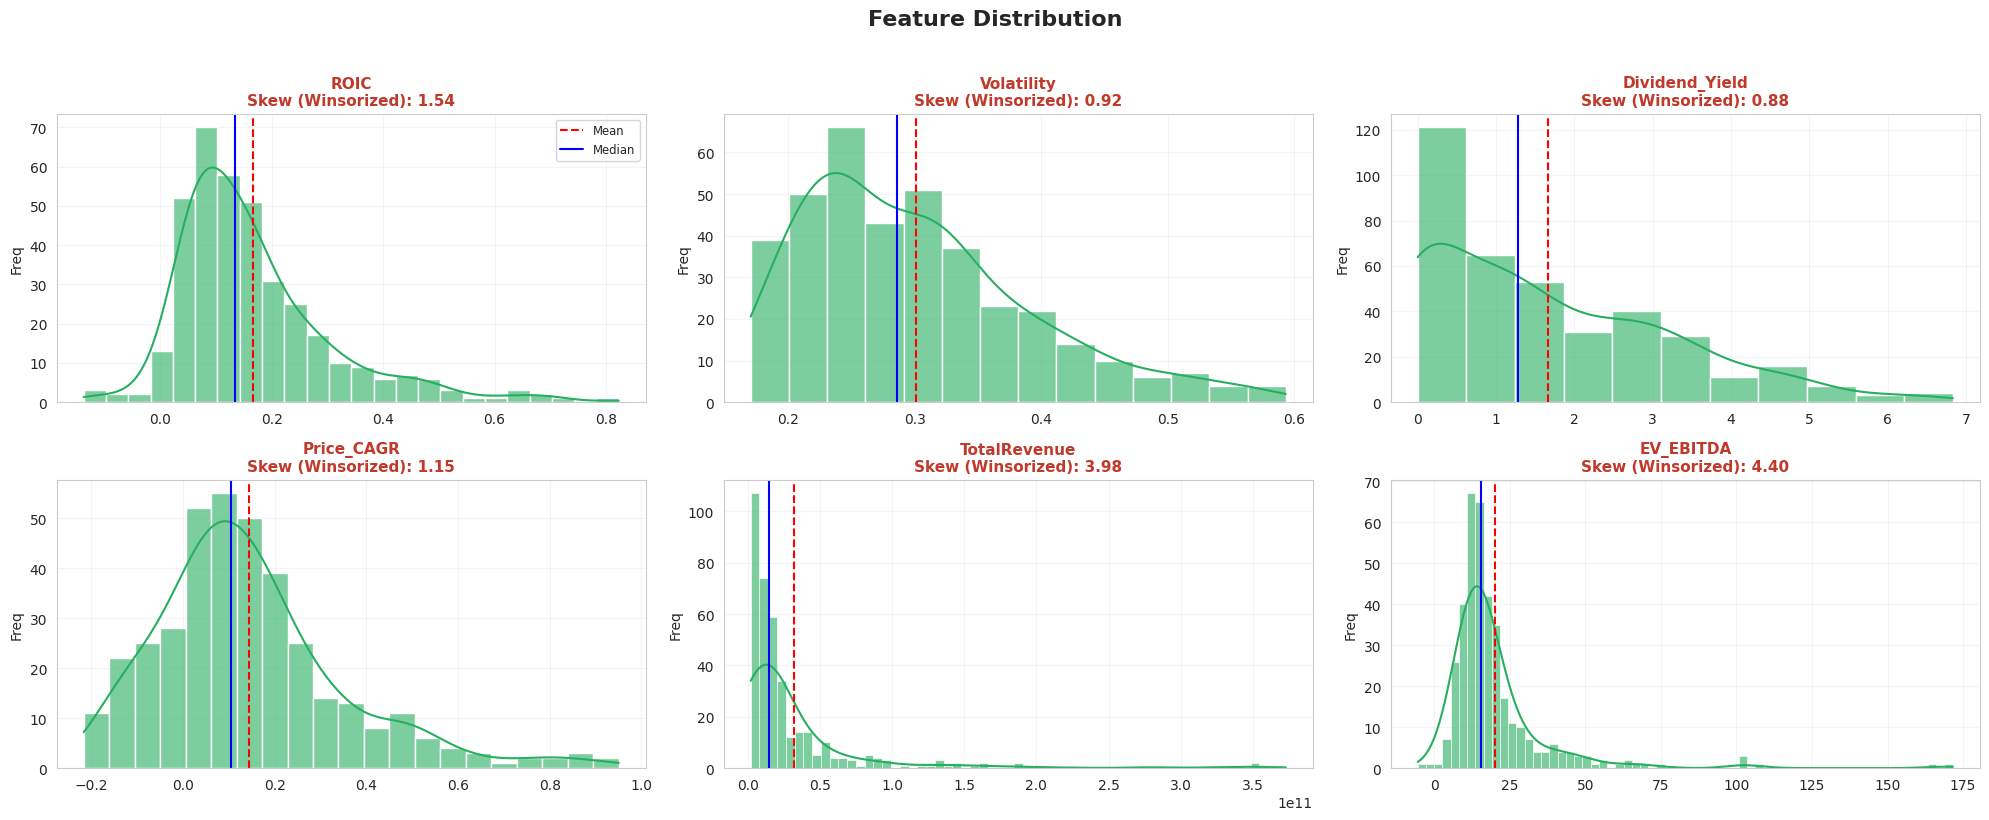

In [9]:
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(num_cols):

    # Data Prep (Winsorize 1-99% Visual Only)
    data_raw = df_eda[col].dropna()

    # Hitung batas quantile
    q_low = data_raw.quantile(0.01)
    q_high = data_raw.quantile(0.99)

    # Filter data untuk visualisasi
    data_viz = data_raw[(data_raw >= q_low) & (data_raw <= q_high)]

    # Plot Histogram (Hijau Standar)
    sns.histplot(data_viz, kde=True, ax=axs[i], color='#27ae60', alpha=0.6, edgecolor='white')

    # Hitung Statistik
    skew_val = data_viz.skew()
    mean_val = data_viz.mean()
    median_val = data_viz.median()

    # Tambahkan Garis Referensi (Mean & Median)
    # Ini membantu melihat apakah Mean tertarik ke kanan/kiri oleh outlier sisa
    axs[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label='Mean')
    axs[i].axvline(median_val, color='blue', linestyle='-', linewidth=1.5, label='Median')

    # Merah jika Skewness > 0.5 (Moderately Skewed) atau > 1 (Highly Skewed)
    is_skewed = abs(skew_val) > 0.5
    title_color = '#c0392b' if is_skewed else 'black'
    font_weight = 'bold' if is_skewed else 'normal'

    axs[i].set_title(f'{col}\nSkew (Winsorized): {skew_val:.2f}',
                     fontsize=11, fontweight=font_weight, color=title_color)

    # Kosmetik
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Freq')
    axs[i].grid(True, alpha=0.2)

    # Tampilkan legend hanya di plot pertama
    if i == 0:
        axs[i].legend(loc='upper right', fontsize='small')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Feature Distribution", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Outliers

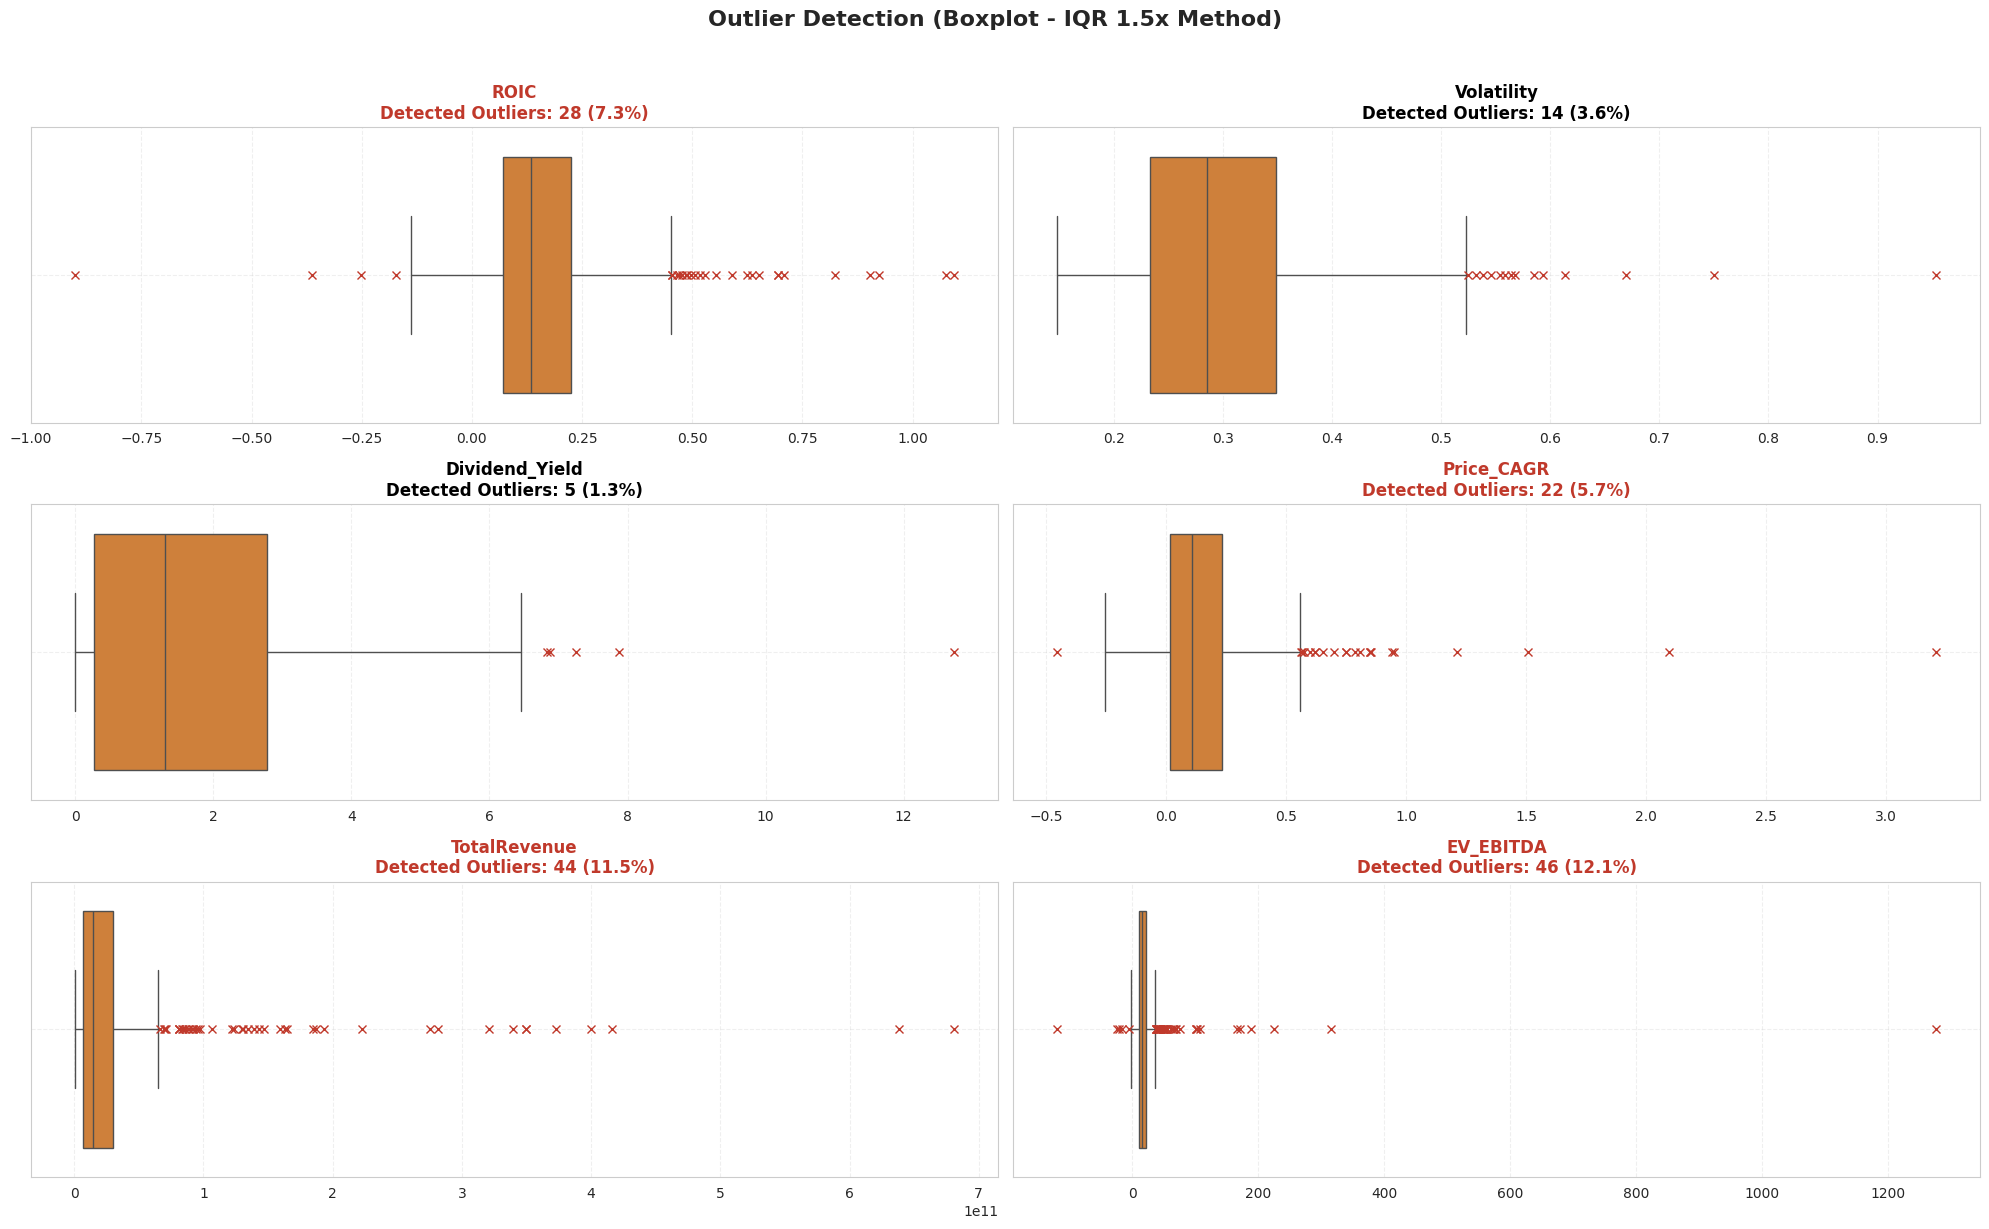

In [10]:
n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(num_cols):

    # Ambil data bersih untuk perhitungan statistik
    data_clean = df_eda[col].dropna()

    # Hitung Statistik IQR Manual
    Q1 = data_clean.quantile(0.25)
    Q3 = data_clean.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung Jumlah & Persentase Outlier
    n_outliers = ((data_clean < lower_bound) | (data_clean > upper_bound)).sum()
    pct_outliers = (n_outliers / len(data_clean)) * 100

    # Visualisasi Boxplot
    # flierprops = properti untuk titik-titik outlier (kita buat silang merah biar jelas)
    sns.boxplot(x=df_eda[col], ax=axs[i], color='#e67e22',
                flierprops={"marker": "x", "markeredgecolor": "#c0392b", "markersize": 6})

    # Jika outlier > 5%, beri warna merah pada judul sebagai "Warning"
    title_color = '#c0392b' if pct_outliers > 5 else 'black'

    axs[i].set_title(f'{col}\nDetected Outliers: {n_outliers} ({pct_outliers:.1f}%)',
                     fontsize=12, fontweight='bold', color=title_color)

    axs[i].set_xlabel('')
    axs[i].grid(True, linestyle='--', alpha=0.3)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Outlier Detection (Boxplot - IQR 1.5x Method)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Correlation Heatmap

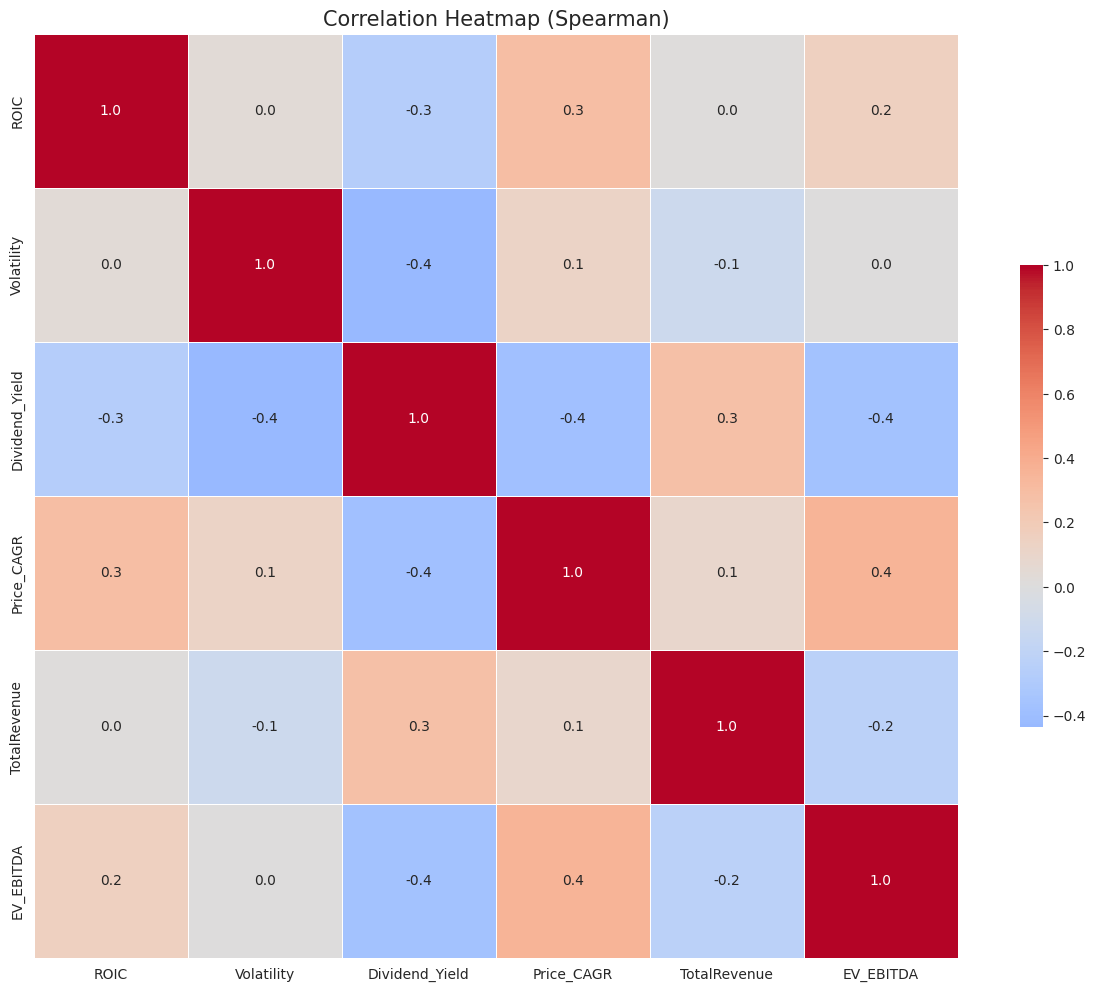

In [11]:
plt.figure(figsize=(16, 12))
corr = df_eda[num_cols].corr(method='spearman')

sns.heatmap(
    corr,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Correlation Heatmap (Spearman)', fontsize=15)
plt.show()

# Preprocessing

In [12]:
initial_shape = df.shape
df = df.dropna()
print(f"Data Loaded : {initial_shape}")
print(f"Data Cleaned: {df.shape}")

Data Loaded : (384, 8)
Data Cleaned: (379, 8)


In [13]:
# Memotong outlier ekstrem pada batas persentil tertentu
def winsorize_series(series):
    q_low = series.quantile(0.01)
    q_high = series.quantile(0.99)
    return series.clip(lower=q_low, upper=q_high)

# Melakukan transformasi Log, Winsorizing, dan Scaling
def preprocess_features(df, features):
    X = df[features].copy()

    # 1. Log Transformation (Handling Skewness)
    X['TotalRevenue'] = np.log1p(X['TotalRevenue'])

    # Handle Negative EV/EBITDA before Log
    min_ev = X['EV_EBITDA'].min()
    if min_ev < 0:
        X['EV_EBITDA'] = X['EV_EBITDA'] - min_ev + 1
    X['EV_EBITDA'] = np.log1p(X['EV_EBITDA'])

    # 2. Winsorizing
    for col in features:
        X[col] = winsorize_series(X[col])

    # 3. Scaling
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    return X, X_scaled, scaler

In [14]:
# Preprocessing Pipeline
X_transformed, X_scaled, scaler_model = preprocess_features(df, num_cols)

# Dimensionality Reduction (PCA)

In [15]:
# Initialize PCA
pca_model = PCA(n_components=2, random_state=42)
X_pca = pca_model.fit_transform(X_scaled)

# Explainability Check
var_ratio = pca_model.explained_variance_ratio_
print(f"PCA Explained Variance: {var_ratio}")
print(f"Total Information Retained: {sum(var_ratio):.2%}")

PCA Explained Variance: [0.50580352 0.18561667]
Total Information Retained: 69.14%


# Hyperparameter Tuning (Finding Best K)

In [16]:
k_min = 2
k_max = 11
range_n_clusters = list(range(k_min, k_max))
best_score = -1
best_k = -1
best_kmeans_model = None

metrics_data = []

for k in range_n_clusters:
    # Init K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    # Calculate Metrics
    sil_score = silhouette_score(X_pca, labels)
    dbi_score = davies_bouldin_score(X_pca, labels)

    # Store results
    metrics_data.append({
        'K': k,
        'Silhouette Score': sil_score,
        'DBI Score': dbi_score
    })

    # Update Best Model Logic (Maximize Silhouette)
    if sil_score > best_score:
        best_score = sil_score
        best_k = k
        best_kmeans_model = kmeans

metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index('K', inplace=True)

print("Optimization Results:")
display(metrics_df.round(4))

print(f"Optimal K Found: {best_k}")

Optimization Results:


,Silhouette Score,DBI Score
K,,
2,0.7403,0.5953
3,0.4554,0.8495
4,0.4913,0.7617
5,0.3696,0.8218
6,0.3644,0.7954
7,0.3425,0.8078
8,0.3329,0.8311
9,0.3477,0.8271
10,0.3460,0.8079


Optimal K Found: 2


# Visualization

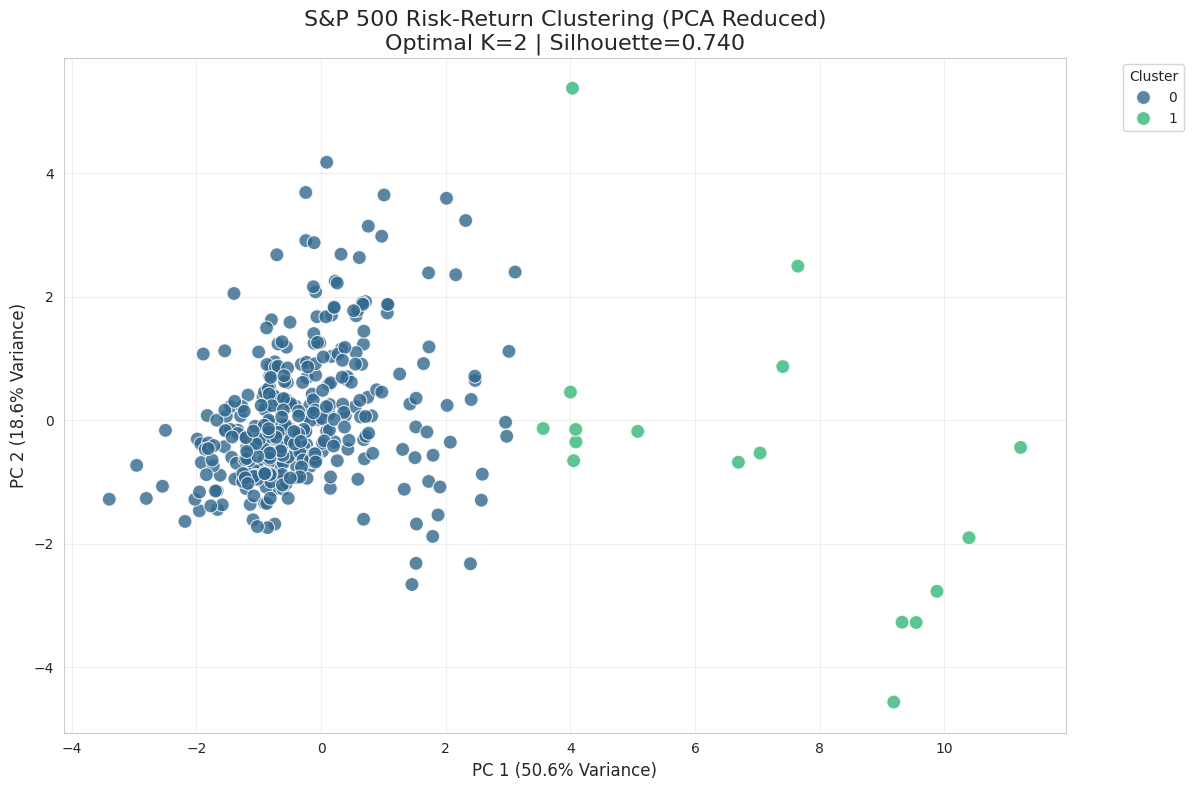

In [17]:
# Assign Labels to Original Data
final_labels = best_kmeans_model.predict(X_pca)
df['Cluster'] = final_labels

# Visualization
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=final_labels,
    palette='viridis',
    s=100,
    alpha=0.8,
    edgecolor='w'
)

plt.title(f'S&P 500 Risk-Return Clustering (PCA Reduced)\nOptimal K={best_k} | Silhouette={best_score:.3f}', fontsize=16)
plt.xlabel(f'PC 1 ({var_ratio[0]:.1%} Variance)', fontsize=12)
plt.ylabel(f'PC 2 ({var_ratio[1]:.1%} Variance)', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster Profiling & Interpretation

In [18]:
# Mean Features per Cluster
cluster_means = df.groupby('Cluster')[num_cols].mean()

# Global Median (Baseline)
global_median = df[num_cols].median()

# Member Counts
cluster_counts = df['Cluster'].value_counts().sort_index().to_frame(name='Total Members')

labels = []
descriptions = []

for cluster_id in cluster_means.index:
    row = cluster_means.loc[cluster_id]

    # A. LOGIC LABEL
    if row['EV_EBITDA'] > global_median['EV_EBITDA'] * 2.5:
        label = "SPECULATIVE"
    elif row['Dividend_Yield'] > 1.5 and row['Volatility'] < global_median['Volatility']:
        label = "DEFENSIVE"
    elif row['Price_CAGR'] > global_median['Price_CAGR'] * 1.5:
        label = "GROWTH"
    elif row['ROIC'] > 0.20:
        label = "QUALITY"
    else:
        label = "CORE"

    labels.append(label)

    # B. LOGIC DESKRIPSI SINGKAT
    traits = []

    # Valuasi
    if row['EV_EBITDA'] > global_median['EV_EBITDA'] * 2.0:
        traits.append("Valuasi Sangat Premium")
    elif row['EV_EBITDA'] < global_median['EV_EBITDA'] * 0.8:
        traits.append("Valuasi Terdiskon/Murah")
    else:
        traits.append("Valuasi Wajar")

    # Risiko
    if row['Volatility'] < global_median['Volatility'] * 0.9:
        traits.append("Risiko Rendah")
    elif row['Volatility'] > global_median['Volatility'] * 1.1:
        traits.append("Risiko Tinggi")
    else:
        traits.append("Risiko Moderat")

    # Dividen
    if row['Dividend_Yield'] > 1.2:
        traits.append("Rutin Dividen")
    else:
        traits.append("Minim Dividen")

    descriptions.append(", ".join(traits))

# DF 1: Counts
df_counts = cluster_counts
df_counts.index.name = 'Cluster'

# DF 2: Characteristics
df_characteristics = pd.DataFrame({
    'Cluster Label': labels,
    'Short Description': descriptions
}, index=cluster_means.index)
df_characteristics.index.name = 'Cluster'

# DF 3: Profiling (Quantitative)
df_profile = cluster_means.round(4)
df_profile.index.name = 'Cluster'

print("Member Distribution ")
display(df_counts)

print("\nCluster Characteristics ")
with pd.option_context('display.max_colwidth', None):
    display(df_characteristics)

print("\nQuantitative Profile (Mean) ")
display(df_profile)

Member Distribution 


,Total Members
Cluster,
0,362
1,17



Cluster Characteristics 


,Cluster Label,Short Description
Cluster,,
0,CORE,"Valuasi Wajar, Risiko Moderat, Rutin Dividen"
1,SPECULATIVE,"Valuasi Sangat Premium, Risiko Tinggi, Minim Dividen"



Quantitative Profile (Mean) 


,ROIC,Volatility,Dividend_Yield,Price_CAGR,TotalRevenue,EV_EBITDA
Cluster,,,,,,
0,0.1700,0.2946,1.8219,0.1288,3.717485e+10,16.5198
1,0.1587,0.4832,0.2388,0.7299,2.734610e+10,187.6664


# Export Model

In [19]:
data_labeled = 'sp500_risk_return_labeled.csv'
df.to_csv(data_labeled, index=False)
print(f"Data berlabel cluster disimpan ke: {data_labeled}")

model_name = 'sp500_risk_return_model.joblib'
model_artifacts = {
    'scaler': scaler_model,
    'pca': pca_model,
    'kmeans': best_kmeans_model,
    'features': num_cols,
    'winsor_limits': (0.01, 0.99)
}

joblib.dump(model_artifacts, model_name)
print(f"Model artifacts disimpan ke: {model_name}")

Data berlabel cluster disimpan ke: sp500_risk_return_labeled.csv
Model artifacts disimpan ke: sp500_risk_return_model.joblib
